In [1]:
import sys
from pathlib import Path
import warnings
import re

from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ------------------------------------------------
# Robustly locate the project root so we can import src.config
# ------------------------------------------------
def find_project_root() -> Path:
    cwd = Path.cwd().resolve()
    candidates = [
        cwd,
        cwd.parent,
        cwd.parent.parent,
    ]

    for candidate in candidates:
        if (candidate / "src" / "config.py").exists():
            return candidate

    raise RuntimeError(
        f"Could not locate project root from {cwd}. "
        "Tried current directory and two parents."
    )


ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.config import GCP_PROJECT_ID, BQ_DATASET

# -------------------------------------------------------------------
# BigQuery client and table names
# -------------------------------------------------------------------
client = bigquery.Client(project=GCP_PROJECT_ID)

TABLE_PLAYERS = f"{GCP_PROJECT_ID}.{BQ_DATASET}.player_advanced_stats_2024_25"
TABLE_LEAGUE  = f"{GCP_PROJECT_ID}.{BQ_DATASET}.league_table_enhanced_2024_25"

# -------------------------------------------------------------------
# Matplotlib defaults
# -------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10


In [2]:
# -------------------------------------------------------------------
# Config: column names
# -------------------------------------------------------------------
CLUB_COL      = "club"
PLAYER_COL    = "player_name"
POSITION_COL  = "position"

MINUTES_COL   = "min"
NINETIES_COL  = "90s"

# usage components
USAGE_COMPONENTS = [
    "shots",
    "misplaced_passes",
    "miscontrols",
    "dispossessed",
    "failed_take_ons",
]

TARGET_CLUB   = "swansea city"
MIN_NINETIES  = 10  # for scatter filters


# -------------------------------------------------------------------
# Load tables from BigQuery
# -------------------------------------------------------------------
players_query = f"SELECT * FROM `{TABLE_PLAYERS}`"
league_query  = f"SELECT * FROM `{TABLE_LEAGUE}`"

players = client.query(players_query).to_dataframe()
league  = client.query(league_query).to_dataframe()

# -------------------------------------------------------------------
# Filter to Swansea City only (case-insensitive exact match)
# -------------------------------------------------------------------
players_swans = players[
    players[CLUB_COL].astype(str).str.lower() == TARGET_CLUB
].copy()

league_swans = league[
    league[CLUB_COL].astype(str).str.lower() == TARGET_CLUB
].copy()

#print("Players for Swansea City:", len(players_swans))

# -------------------------------------------------------------------
# Basic checks - required columns from schema
# -------------------------------------------------------------------
required_cols = (
    USAGE_COMPONENTS
    + [NINETIES_COL, MINUTES_COL, POSITION_COL]
    + [
        "prgc",
        "prgp",
        "p90_g+a",
        "p90_xg+xag",
        "sca90",
    ]
)

missing = [c for c in required_cols if c not in players_swans.columns]
if missing:
    raise ValueError(
        f"Missing required columns from player_advanced_stats_2024_25: {missing}"
    )

# -------------------------------------------------------------------
# Compute raw usage + p90_usage
# -------------------------------------------------------------------
players_swans["usage"] = players_swans[USAGE_COMPONENTS].fillna(0).sum(axis=1)

players_swans[NINETIES_COL] = players_swans[NINETIES_COL].replace(0, np.nan)
players_swans["p90_usage"] = players_swans["usage"] / players_swans[NINETIES_COL]

# -------------------------------------------------------------------
# Compute p90_prgc and p90_prgp from prgc/prgp and 90s
# -------------------------------------------------------------------
players_swans["p90_prgc"] = players_swans["prgc"] / players_swans[NINETIES_COL]
players_swans["p90_prgp"] = players_swans["prgp"] / players_swans[NINETIES_COL]

# -------------------------------------------------------------------
# Alias table per-90 columns to simpler names
# -------------------------------------------------------------------
players_swans["p90_ga"]     = players_swans["p90_g+a"]      # goals + assists per 90
players_swans["p90_xg_xag"] = players_swans["p90_xg+xag"]   # xG + xAG per 90


In [3]:
# ------------------------------------------------
# Position → coarse role mapping & grouping
# ------------------------------------------------
ROLE_ORDER = ["GK", "DF", "MF", "FW", "Other"]

def _map_token_to_role(token: str) -> str:
    """Map a single raw token (e.g. 'AM', 'WB') to a coarse role."""
    t = token.upper()

    # Forwards
    if t.startswith(("FW", "ST", "CF")):
        return "FW"

    # Midfielders
    if t.startswith(("MF", "AM", "DM", "CM", "LM", "RM")):
        return "MF"

    # Defenders
    if t.startswith(("DF", "FB", "WB", "CB", "RB", "LB")):
        return "DF"

    # Goalkeepers
    if t.startswith("GK"):
        return "GK"

    return "Other"


def simplify_pos(pos: str) -> str:
    """
    Simplify position strings into:
      - single roles: 'FW', 'MF', 'DF', 'GK', 'Other'
      - or hybrid roles: 'FW/MF', 'DF/MF', etc.
    """
    if not isinstance(pos, str):
        return "Other"

    # Split on commas, slashes, semicolons, whitespace
    tokens = re.split(r"[,/; ]+", pos)
    tokens = [t for t in tokens if t]

    if not tokens:
        return "Other"

    roles = {_map_token_to_role(tok) for tok in tokens}

    # If we have recognised roles + "Other", drop "Other"
    if len(roles) > 1 and "Other" in roles:
        roles.discard("Other")

    if not roles:
        return "Other"

    # Single-role case
    if len(roles) == 1:
        return next(iter(roles))

    # Multi-role case → stable label like 'DF/MF' or 'DF/MF/FW'
    ordered = [r for r in ROLE_ORDER if r in roles]
    return "/".join(ordered)


# Ensure pos_group exists on Swansea players
players_swans["pos_group"] = players_swans[POSITION_COL].apply(simplify_pos)

# Build a distinct colour for each pos_group (single or hybrid)
pos_groups = sorted(players_swans["pos_group"].dropna().unique())

base_colors = {
    "FW": np.array([1.0, 0.2, 0.2]),
    "MF": np.array([0.2, 0.4, 1.0]),
    "DF": np.array([0.2, 1.0, 0.4]),
    "GK": np.array([0.0, 0.0, 0.0]),
    "Other": np.array([0.7, 0.7, 0.7]),
}

def blend_roles(role_label: str):
    roles = role_label.split("/")
    cols = [base_colors.get(r, base_colors["Other"]) for r in roles]
    return tuple(np.mean(cols, axis=0))

pos_palette = {group: blend_roles(group) for group in pos_groups}


def add_diagonal_mean_line(ax, x_vals, y_vals):
    """
    Add a visually 45° 'diagonal' reference line through the mean point
    of the given data for THIS plot.

    - Uses only x_vals / y_vals for this subplot.
    - Uses the current axis limits to choose slope so it *looks* 45°
      on screen.
    - Call this AFTER all set_xlim/set_ylim for that plot.
    """
    x_vals = np.asarray(x_vals, dtype=float)
    y_vals = np.asarray(y_vals, dtype=float)
    mask = np.isfinite(x_vals) & np.isfinite(y_vals)
    if mask.sum() == 0:
        return

    x = x_vals[mask]
    y = y_vals[mask]

    mx, my = x.mean(), y.mean()

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    if xmax == xmin:
        return

    # Slope chosen so it appears 45° given current axis ranges
    m = (ymax - ymin) / (xmax - xmin)

    x_line = np.linspace(xmin, xmax, 200)
    y_line = my + m * (x_line - mx)

    ax.plot(x_line, y_line, linestyle="--", linewidth=1)


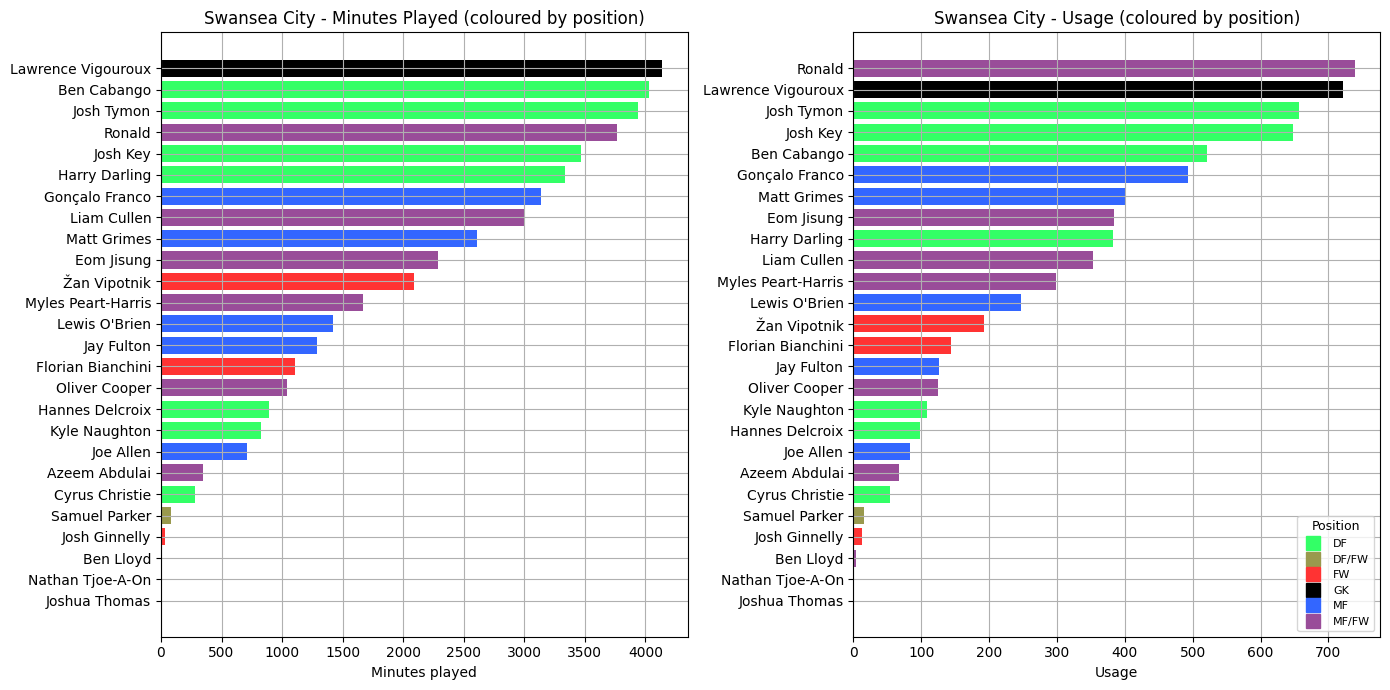

In [4]:
# -------------------------------------------------------------------
# Bar charts: minutes played vs raw usage (side by side)
#   - First chart sorted by minutes (min)
#   - Second chart sorted by usage
#   - Coloured by pos_group
#   - No shared y-axis
# -------------------------------------------------------------------

for col in [MINUTES_COL, "usage", "pos_group"]:
    if col not in players_swans.columns:
        raise ValueError(f"Missing column needed for bar charts: {col}")

# Sort separately for each chart
df_minutes = players_swans.copy().sort_values(MINUTES_COL, ascending=False)
df_usage   = players_swans.copy().sort_values("usage", ascending=False)

player_labels_minutes = df_minutes[PLAYER_COL].astype(str)
player_labels_usage   = df_usage[PLAYER_COL].astype(str)

colors_minutes = df_minutes["pos_group"].map(pos_palette).tolist()
colors_usage   = df_usage["pos_group"].map(pos_palette).tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# -------- Left: Minutes played (sorted by minutes) --------
axes[0].barh(
    player_labels_minutes,
    df_minutes[MINUTES_COL],
    color=colors_minutes,
)
axes[0].invert_yaxis()
axes[0].set_xlabel("Minutes played")
axes[0].set_title("Swansea City - Minutes Played (coloured by position)")

# -------- Right: Usage (sorted by usage) --------
axes[1].barh(
    player_labels_usage,
    df_usage["usage"],
    color=colors_usage,
)
axes[1].invert_yaxis()
axes[1].set_xlabel("Usage")
axes[1].set_title("Swansea City - Usage (coloured by position)")

# Legend for positions
handles = []
for group in sorted(pos_palette.keys()):
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="s",
            color=pos_palette[group],
            linestyle="",
            markersize=10,
            label=group,
        )
    )

axes[1].legend(
    handles=handles,
    title="Position",
    fontsize=8,
    title_fontsize=9,
    loc="lower right",
)

plt.tight_layout()
plt.show()


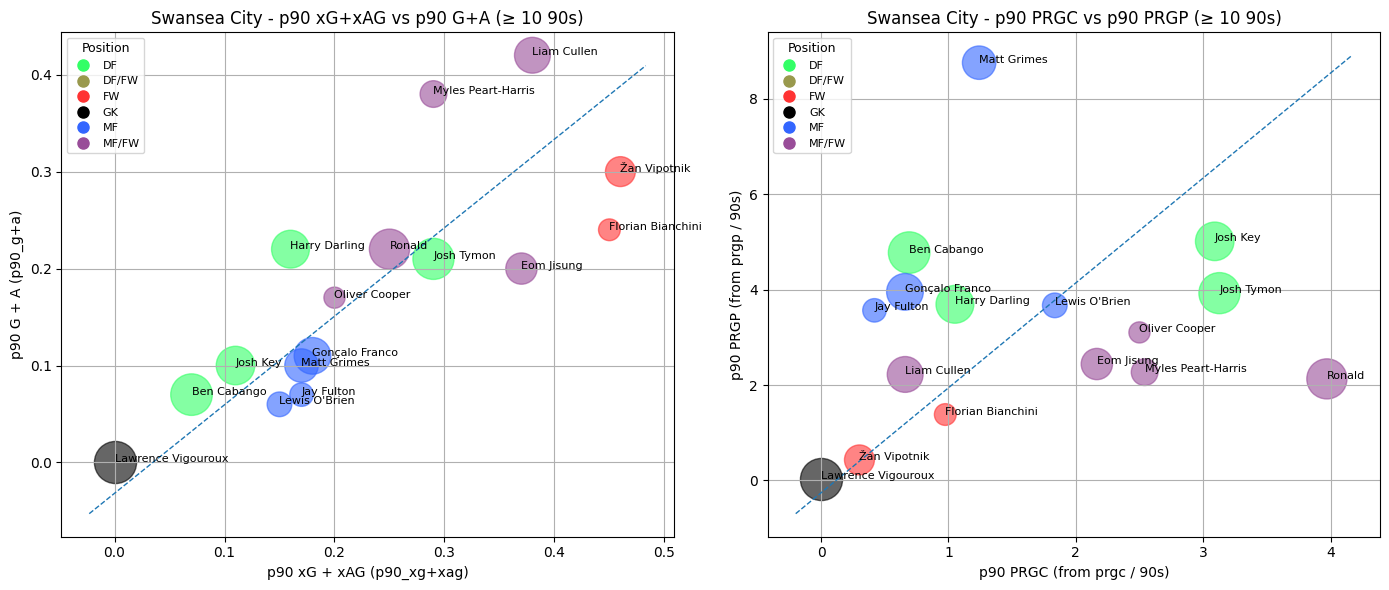

In [5]:
# -------------------------------------------------------------------
# Scatter: p90 xG+xAG vs p90 G+A, and p90 PRGC vs p90 PRGP
#   - Only players with at least MIN_NINETIES * 90s
#   - Colour by pos_group
#   - Dot size = 90s * 20
#   - Dot transparency alpha=0.6
#   - Per-plot diagonal mean-reference line
# -------------------------------------------------------------------

required_cols = [
    "p90_xg_xag", "p90_ga", "p90_prgc", "p90_prgp",
    PLAYER_COL, NINETIES_COL, "pos_group"
]
missing = [c for c in required_cols if c not in players_swans.columns]
if missing:
    raise ValueError(f"Missing required columns for scatter plots: {missing}")

df_scatter = players_swans[players_swans[NINETIES_COL] >= MIN_NINETIES].copy()

df_xg_ga = df_scatter[["p90_xg_xag", "p90_ga", PLAYER_COL, "pos_group", NINETIES_COL]].dropna()
df_prg   = df_scatter[["p90_prgc", "p90_prgp", PLAYER_COL, "pos_group", NINETIES_COL]].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -------- Left: p90 xG+xAG vs p90 G+A --------
for group in sorted(df_xg_ga["pos_group"].unique()):
    sub = df_xg_ga[df_xg_ga["pos_group"] == group]
    axes[0].scatter(
        sub["p90_xg_xag"].astype(float),
        sub["p90_ga"].astype(float),
        s=sub[NINETIES_COL] * 20,
        alpha=0.6,
        color=pos_palette.get(group, base_colors["Other"]),
        label=group,
    )
    for _, row in sub.iterrows():
        axes[0].annotate(
            row[PLAYER_COL],
            (float(row["p90_xg_xag"]), float(row["p90_ga"])),
            fontsize=8,
        )

axes[0].set_xlabel("p90 xG + xAG (p90_xg+xag)")
axes[0].set_ylabel("p90 G + A (p90_g+a)")
axes[0].set_title(f"Swansea City - p90 xG+xAG vs p90 G+A (≥ {MIN_NINETIES} 90s)")

add_diagonal_mean_line(axes[0], df_xg_ga["p90_xg_xag"], df_xg_ga["p90_ga"])

handles = [
    plt.Line2D([0], [0], marker="o", linestyle="", color=pos_palette[g], markersize=8, label=g)
    for g in sorted(pos_palette.keys())
]
axes[0].legend(handles=handles, title="Position", fontsize=8, title_fontsize=9)


# -------- Right: p90 PRGC vs p90 PRGP --------
for group in sorted(df_prg["pos_group"].unique()):
    sub = df_prg[df_prg["pos_group"] == group]
    axes[1].scatter(
        sub["p90_prgc"].astype(float),
        sub["p90_prgp"].astype(float),
        s=sub[NINETIES_COL] * 20,
        alpha=0.6,
        color=pos_palette.get(group, base_colors["Other"]),
        label=group,
    )
    for _, row in sub.iterrows():
        axes[1].annotate(
            row[PLAYER_COL],
            (float(row["p90_prgc"]), float(row["p90_prgp"])),
            fontsize=8,
        )

axes[1].set_xlabel("p90 PRGC (from prgc / 90s)")
axes[1].set_ylabel("p90 PRGP (from prgp / 90s)")
axes[1].set_title(f"Swansea City - p90 PRGC vs p90 PRGP (≥ {MIN_NINETIES} 90s)")

add_diagonal_mean_line(axes[1], df_prg["p90_prgc"], df_prg["p90_prgp"])

# Legend (normal-sized markers)
handles = [
    plt.Line2D([0], [0], marker="o", linestyle="", color=pos_palette[g], markersize=8, label=g)
    for g in sorted(pos_palette.keys())
]
axes[1].legend(handles=handles, title="Position", fontsize=8, title_fontsize=9)

plt.tight_layout()
plt.show()


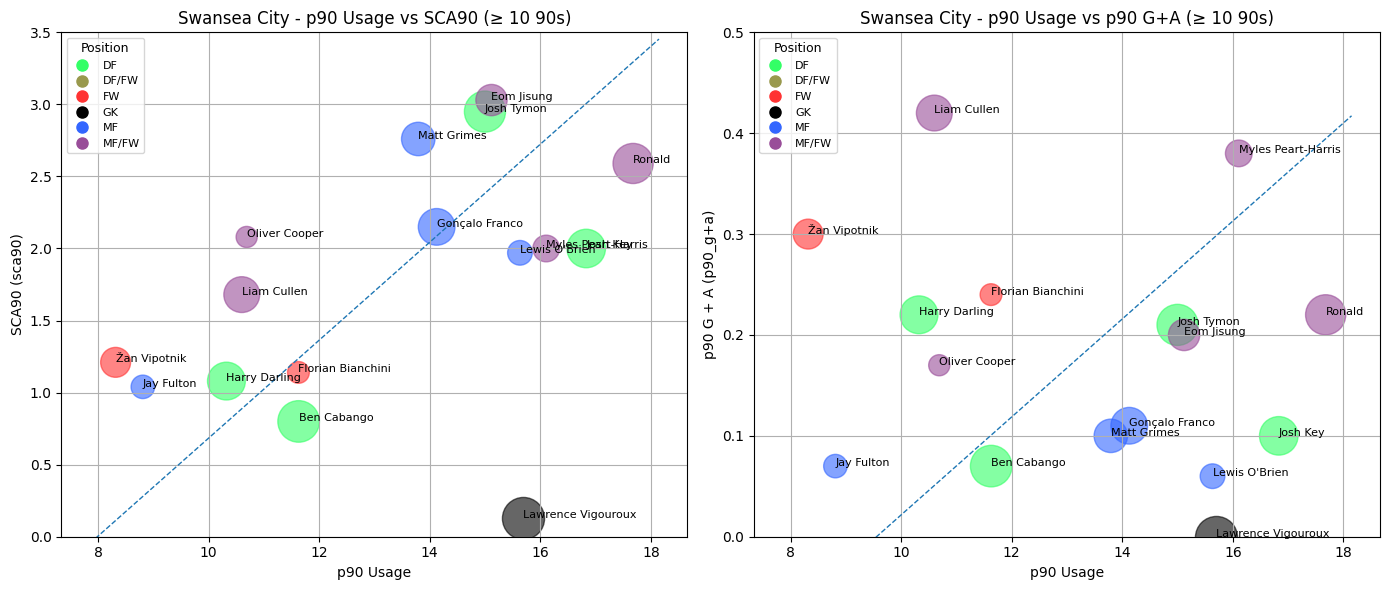

In [6]:
# -------------------------------------------------------------------
# Scatter: p90 usage vs SCA90, and p90 usage vs p90 G+A
#   - Only players with at least MIN_NINETIES * 90s played
#   - Coloured by pos_group
#   - Y-axes fixed:
#         SCA90   → 0 to 3.5
#         p90 G+A → 0 to 0.5
#   - Dot size = 90s * 20
#   - alpha = 0.6 for overlap visibility
#   - Diagonal line computed per-plot AFTER limits are set
# -------------------------------------------------------------------
required = ["p90_usage", "sca90", "p90_ga", PLAYER_COL, NINETIES_COL, "pos_group"]
missing = [c for c in required if c not in players_swans.columns]
if missing:
    raise ValueError(f"Missing columns for p90 usage scatter plots: {missing}")

df_scatter2 = players_swans[players_swans[NINETIES_COL] >= MIN_NINETIES].copy()

# include NINETIES_COL so we can size by 90s
df_usage_sca = df_scatter2[["p90_usage", "sca90", PLAYER_COL, "pos_group", NINETIES_COL]].dropna()
df_usage_ga  = df_scatter2[["p90_usage", "p90_ga", PLAYER_COL, "pos_group", NINETIES_COL]].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

# -------- Left: p90 usage vs SCA90 --------
for group in sorted(df_usage_sca["pos_group"].unique()):
    sub = df_usage_sca[df_usage_sca["pos_group"] == group]
    axes[0].scatter(
        sub["p90_usage"].astype(float),
        sub["sca90"].astype(float),
        s=sub[NINETIES_COL] * 20,
        alpha=0.6,
        label=group,
        color=pos_palette.get(group, base_colors["Other"]),
    )
    for _, row in sub.iterrows():
        axes[0].annotate(
            row[PLAYER_COL],
            (float(row["p90_usage"]), float(row["sca90"])),
            fontsize=8,
        )

axes[0].set_ylim(0, 3.5)
axes[0].set_xlabel("p90 Usage")
axes[0].set_ylabel("SCA90 (sca90)")
axes[0].set_title(f"Swansea City - p90 Usage vs SCA90 (≥ {MIN_NINETIES} 90s)")

add_diagonal_mean_line(axes[0], df_usage_sca["p90_usage"], df_usage_sca["sca90"])

handles = [
    plt.Line2D([0], [0], marker="o", linestyle="", color=pos_palette[g], markersize=8, label=g)
    for g in sorted(pos_palette.keys())
]
axes[0].legend(handles=handles, title="Position", fontsize=8, title_fontsize=9)

# -------- Right: p90 usage vs p90 G+A --------
for group in sorted(df_usage_ga["pos_group"].unique()):
    sub = df_usage_ga[df_usage_ga["pos_group"] == group]
    axes[1].scatter(
        sub["p90_usage"].astype(float),
        sub["p90_ga"].astype(float),
        s=sub[NINETIES_COL] * 20,              # dot size = 90s * 20
        alpha=0.6,
        label=group,
        color=pos_palette.get(group, base_colors["Other"]),
    )
    for _, row in sub.iterrows():
        axes[1].annotate(
            row[PLAYER_COL],
            (float(row["p90_usage"]), float(row["p90_ga"])),
            fontsize=8,
        )

axes[1].set_ylim(0, 0.5)
axes[1].set_xlabel("p90 Usage")
axes[1].set_ylabel("p90 G + A (p90_g+a)")
axes[1].set_title(f"Swansea City - p90 Usage vs p90 G+A (≥ {MIN_NINETIES} 90s)")

add_diagonal_mean_line(axes[1], df_usage_ga["p90_usage"], df_usage_ga["p90_ga"])

handles = []
for group in sorted(pos_palette.keys()):
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            color=pos_palette[group],
            linestyle="",
            markersize=8,
            label=group,
        )
    )

axes[1].legend(handles=handles, title="Position", fontsize=8, title_fontsize=9)

plt.tight_layout()
plt.show()
